### Time Series Anomaly Detection using Tensorflow and Keras in Python

#### Introduction
The purpose of this notebook is to describe, using a sample dataset, the design and implementation in Python of a neural network using Tensorflow and Keras. 
- https://www.brainfacts.org/brain-anatomy-and-function/anatomy/2012/the-neuron
- https://alleninstitute.org/what-we-do/brain-science/news-press/articles/5-unsolved-mysteries-about-brain?gclid=CjwKCAiAzKqdBhAnEiwAePEjkpXxFmskBg7-UvzfIZkSbh5TygbiM0sqD8sTQCOU6c22DPfrx_wbaBoCwcwQAvD_BwE
- https://www.sciencefacts.net/parts-of-a-neuron.html
- https://en.wikipedia.org/wiki/Neural_network
  
1. Neural Networks, Artificial Intelligence and Machine Learning
In biological terms a neuron is one of the fundamental building blocks of the brain, with a human brain containing billions of neurons and trillions of connections between them. These connections, called synapses, allow for electrical signals to be transmitted between neurons, ultimately creating all of the brain functions that are still very far from being understood. A single neuron may be connected to many neurons and in turn it may take inputs from many other neurons. 

Artifical intelligence (AI) is a field associated with developing computer systems that can perform activties that mimic human intelligence, e.g. speech and image recgnition, language processing and decision making. 

Machine Learning (ML) which is a part of AI deals with the creation of methods, algorithms that use data to "learn" and can use this to make predictions about new data that is presented. In a more formal sense it is *the field of study that gives computers the ability to learn without being specifically programmed to do so* - Arthur Samuel,1959. Although the fundamentals of ML go back to the earliest days of computing it is in the last 20 - 30 years that ML models have found their way into many aspects of day to day life, e.g. 
- Email Spam detection
- Credit card fraud Detection.
- Speeech Recognition
- Production Line Inspection
- Predictive Machine Maintenance. 

There are a number of general categories of ML systems based on how the model is to be trained, the pimary being supervised / unsupervised, and reinforeement learning.
- Supervised. This is where the model is provided with a labelled training data set that includes the correct output for the set of inputs. A test data set is used then to validate the accuracy of the model. This project will use a supervised learning approach for model generation. 
- Unsupervised. As the name suggests there is no training data, this is where a number of techniques are used to have the model automatically detect clusters and patterns in the data. 
- Reinforcement. This is a very different ML paradigm where an "agent" can extract information from its environment, perform actions as a result of the data and get rewards (postive or negative) based on those actions. Over time the model is updated to generate the best policy in a given situation that will maximise positive rewards or minimise negative rewards. 






   



In [1]:
# Import packages, describe them.
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from matplotlib import pyplot as plt

In [2]:
#https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
pd.get_option('display.precision')

6

These are the data sources, describe these in both general and specific terms. What NAB and what used for.
https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv
https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv


In [3]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_no_anomaly = pd.read_csv(df_small_noise_url, parse_dates=True, index_col="timestamp")

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_anomaly = pd.read_csv(df_daily_jumpsup_url,parse_dates=True, index_col="timestamp") # note the inex is set as the timestamp so shape is 1.

Check the files vs what is on the web

In [4]:
df_no_anomaly.shape

(4032, 1)

In [5]:
pd.set_option('display.precision',6)

In [6]:
pd.reset_option('display.precision')
df_no_anomaly.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [7]:
df_no_anomaly.iloc[0:2]["value"]

timestamp
2014-04-01 00:00:00    18.324919
2014-04-01 00:05:00    21.970327
Name: value, dtype: float64

In [8]:
df_no_anomaly.iloc[0:5].values[0:5]

array([[18.32491854],
       [21.97032718],
       [18.62480603],
       [21.95368398],
       [21.90911973]])

In [9]:
df_no_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [10]:
df_no_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [11]:
df_daily_anomaly.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


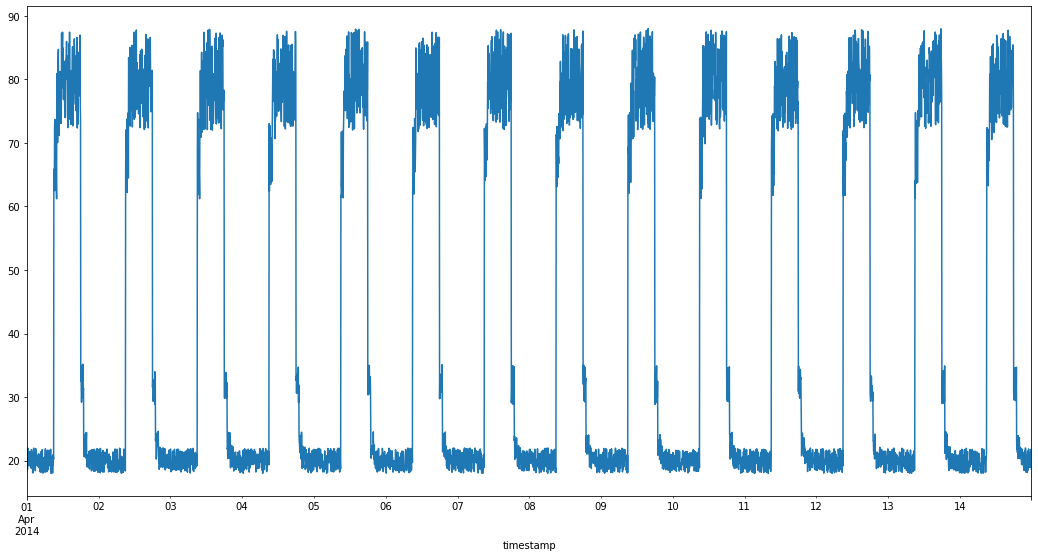

In [12]:
#Have a look at the plot of the small noise file. Hvae a look at using seaborn
fig, ax = plt.subplots(figsize=(18,9))
df_no_anomaly.plot(legend=False, ax=ax);

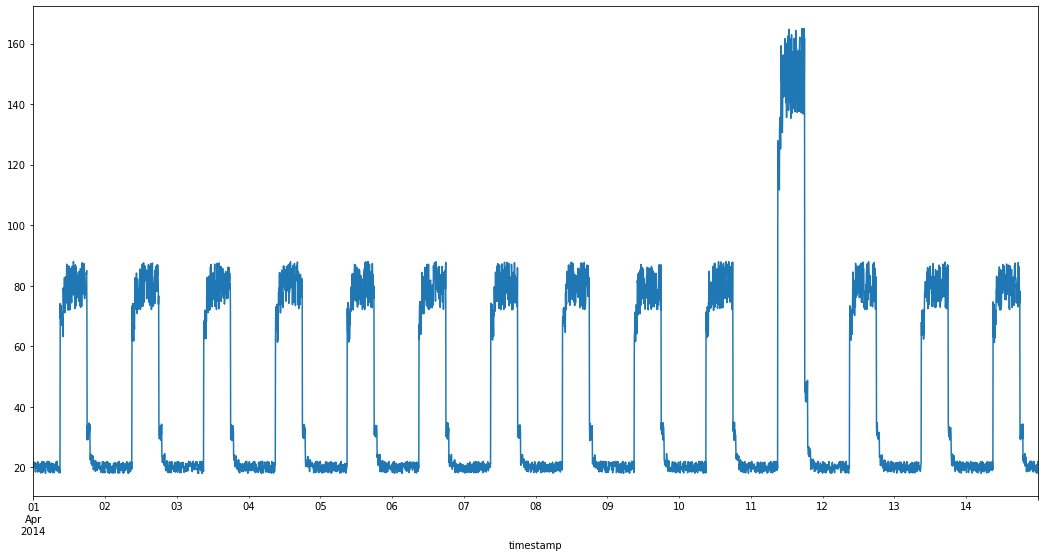

In [13]:
#Have a look at the plot of the small noise file with the anomaly.
fig, ax = plt.subplots(figsize=(18,9))
df_daily_anomaly.plot(legend=False, ax=ax);

### Preprocessing

In [14]:
# Normalize and save the mean and std.
#Variable for the mean of the small noise data set
training_mean = df_no_anomaly.mean()
training_mean

value    42.438353
dtype: float64

In [15]:
#Variable for the std deviation of the small noise data set
training_stdev = df_no_anomaly.std()
training_stdev

value    28.077122
dtype: float64

In [16]:
#Calculate the training value(small noise value - mean/std deviation)
df_training_value = (df_no_anomaly - training_mean) / training_stdev
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [17]:
df_training_value.describe()

,value
count,4.032000e+03
mean,-2.616541e-15
std,1.000000e+00
min,-8.703666e-01
25%,-8.048176e-01
50%,-7.418804e-01
75%,1.175759e+00
max,1.621882e+00


In [18]:
df_training_value

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173
...,...
2014-04-14 23:35:00,-0.791647
2014-04-14 23:40:00,-0.780255
2014-04-14 23:45:00,-0.833640


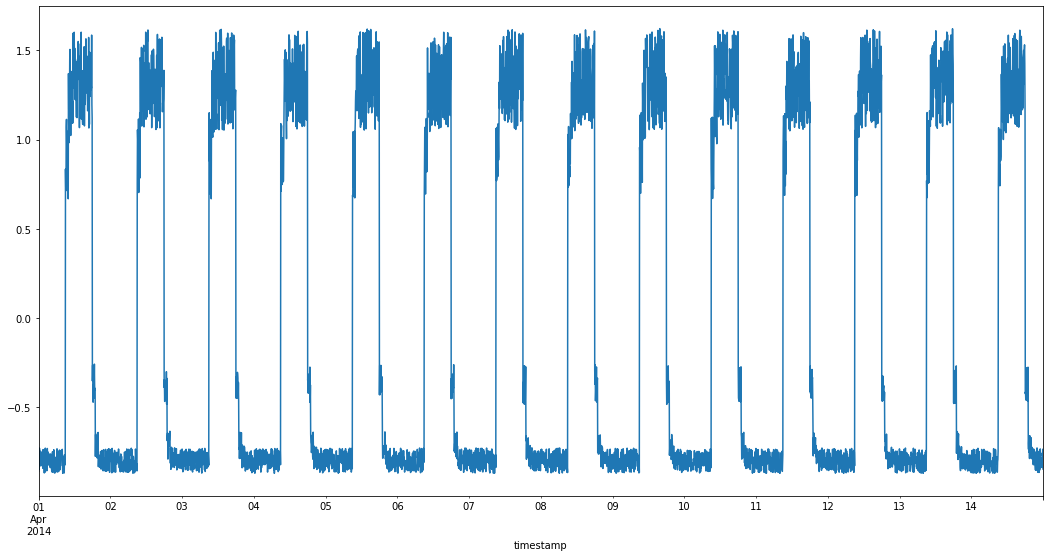

In [19]:
#Have a look at the training data. 
fig, ax = plt.subplots(figsize=(18,9))
df_training_value.plot(legend=False, ax=ax);


In [20]:
#Window size, a sliding window across the data to see the trend of changes across the data. 
#Do window example to describe
time_steps = 288

# Generated training sequences for use in the model.
def create_windows(values, time_steps=time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_windows(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


In [21]:
df_training_value['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

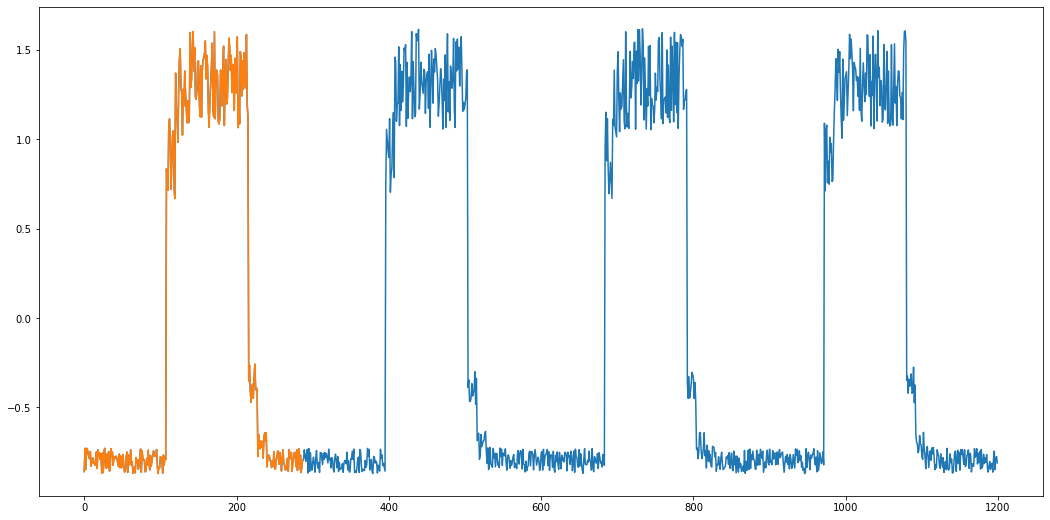

In [22]:
fig, ax = plt.subplots(figsize=(18,9))

y = df_training_value.values[:1200]

ax.plot(y);

w = x_train[0].flatten()

ax.plot(w);

In [23]:
x_train[0]

array([[-0.85882857],
       [-0.72899302],
       [-0.84814772],
       [-0.72958579],
       [-0.731173  ],
       [-0.75730984],
       [-0.77645641],
       [-0.7880838 ],
       [-0.747012  ],
       [-0.829166  ],
       [-0.80377285],
       [-0.7821597 ],
       [-0.81182078],
       [-0.80949918],
       [-0.82334701],
       [-0.79001779],
       [-0.74922405],
       [-0.84169024],
       [-0.73727717],
       [-0.77223023],
       [-0.75311352],
       [-0.79116337],
       [-0.75934728],
       [-0.86809294],
       [-0.75381057],
       [-0.86468256],
       [-0.74361965],
       [-0.72908121],
       [-0.82850668],
       [-0.84043795],
       [-0.76136364],
       [-0.8343536 ],
       [-0.74708881],
       [-0.85574949],
       [-0.85245676],
       [-0.73090636],
       [-0.77440264],
       [-0.74974936],
       [-0.82419543],
       [-0.77402585],
       [-0.78574242],
       [-0.7844733 ],
       [-0.77316412],
       [-0.78843253],
       [-0.80927467],
       [-0

In [24]:
#Redo the  the layers, and add in comments on what they are.
#Figure out what they all mean.

layers = []

### Build the Neural network

In [41]:
#Explain  all of this
#What is a convolutional layer, look up towards data science.
model = keras.Sequential(
    [
        keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        keras.layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_12 (Conv1DT (None, 144, 16)           1808      
_________________________________________________________________
dropout_9 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_13 (Conv1DT (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_14 (Conv1DT (None, 288, 1)           

In [44]:
# Explain what this is, model.fit
#https://keras.io/api/models/model_training_apis/
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")],
)

Epoch 1/5
27/27 [==============================] - 2s 77ms/step - loss: 0.6345 - val_loss: 0.1809
Epoch 2/5
27/27 [==============================] - 2s 77ms/step - loss: 0.1010 - val_loss: 0.0492
Epoch 3/5
27/27 [==============================] - 2s 65ms/step - loss: 0.0621 - val_loss: 0.0372
Epoch 4/5
27/27 [==============================] - 2s 69ms/step - loss: 0.0524 - val_loss: 0.0334
Epoch 5/5
27/27 [==============================] - 2s 65ms/step - loss: 0.0454 - val_loss: 0.0300


In [45]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

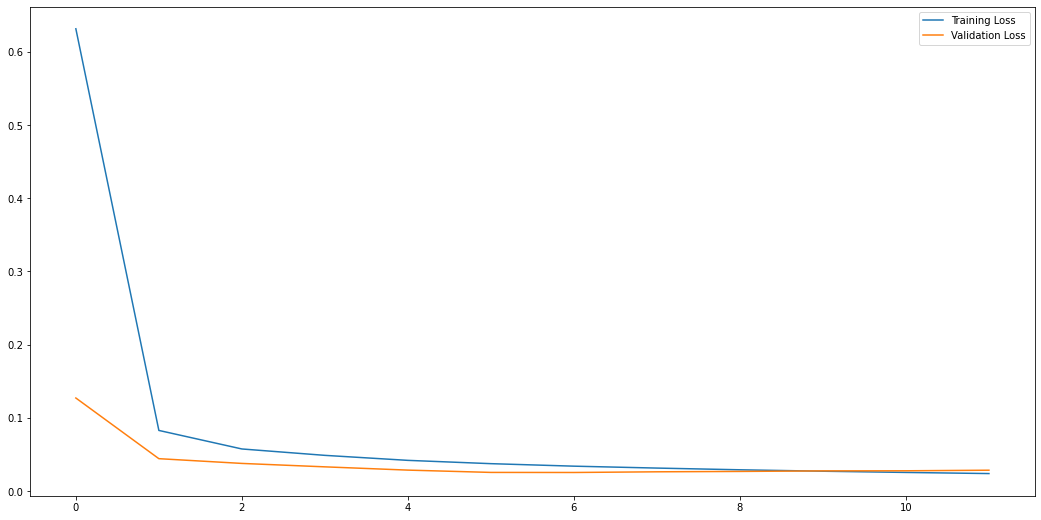

In [27]:
#Get information on model.fit history.
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.figure(figsize=(18,9))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend();

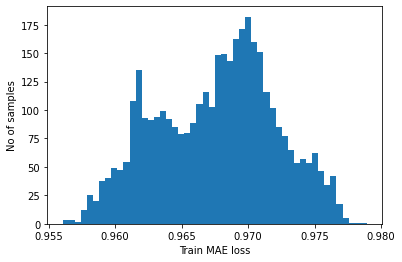

Reconstruction error threshold:  0.9789368733551428


In [43]:
# Get train MAE loss. What is this.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

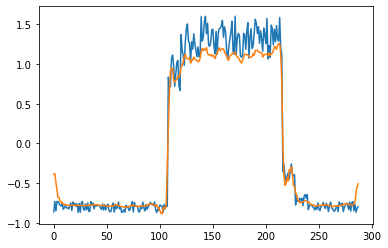

In [29]:
# Checking how the first sequence is learnt, the NN prediction of the output vs the actual output.
plt.plot(x_train[0])
plt.plot(x_train_pred[0]);

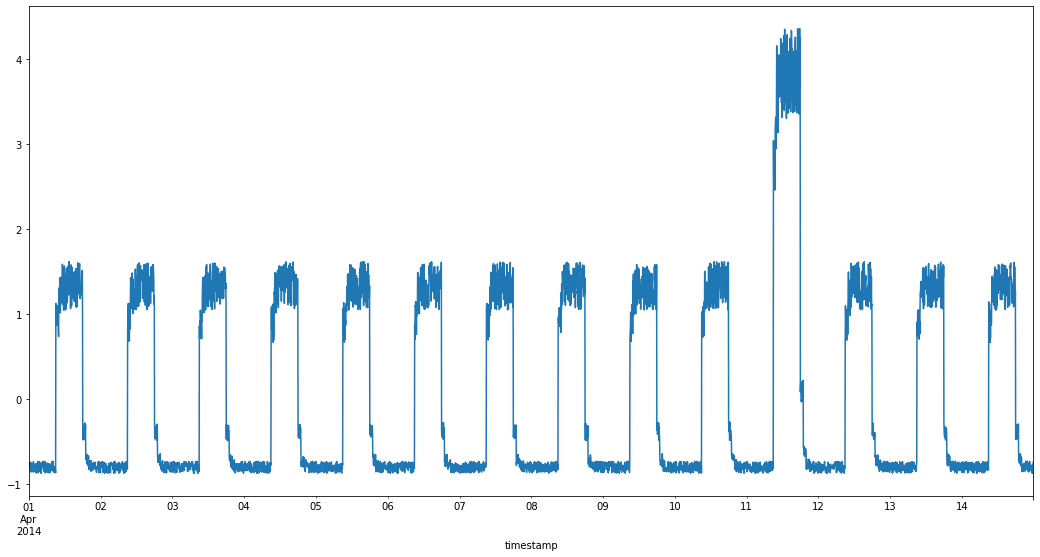

Test input shape:  (3745, 288, 1)


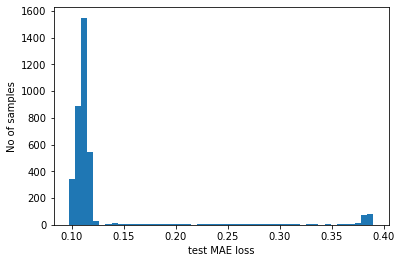

Number of anomaly samples:  401
Indices of anomaly samples:  (array([ 788, 1652, 1653, 1832, 2695, 2696, 2701, 2702, 2703, 2704, 2705,
       2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716,
       2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727,
       2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738,
       2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749,
       2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760,
       2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771,
       2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782,
       2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793,
       2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804,
       2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815,
       2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826,
       2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2

In [30]:

#Break all of this to explain and demonstrate.
df_test_value = (df_daily_anomaly - training_mean) / training_stdev
fig, ax = plt.subplots(figsize=(18,9))
df_test_value.plot(legend=False, ax=ax);
plt.show()

# Create sequences from test values.
x_test = create_windows(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [31]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
#https://www.sharpsightlabs.com/blog/numpy-all/

anomalous_data_indices = []
for data_idx in range(time_steps - 1, len(df_test_value) - time_steps + 1):
    if np.all(anomalies[data_idx - time_steps + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [32]:
df_subset = df_daily_anomaly.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-04-11 09:00:00,127.882020
2014-04-11 09:05:00,115.705719
2014-04-11 09:10:00,122.386410
2014-04-11 09:15:00,127.261178
2014-04-11 09:20:00,121.157997
...,...
2014-04-11 17:40:00,156.009099
2014-04-11 17:45:00,164.947481
2014-04-11 17:50:00,145.758267


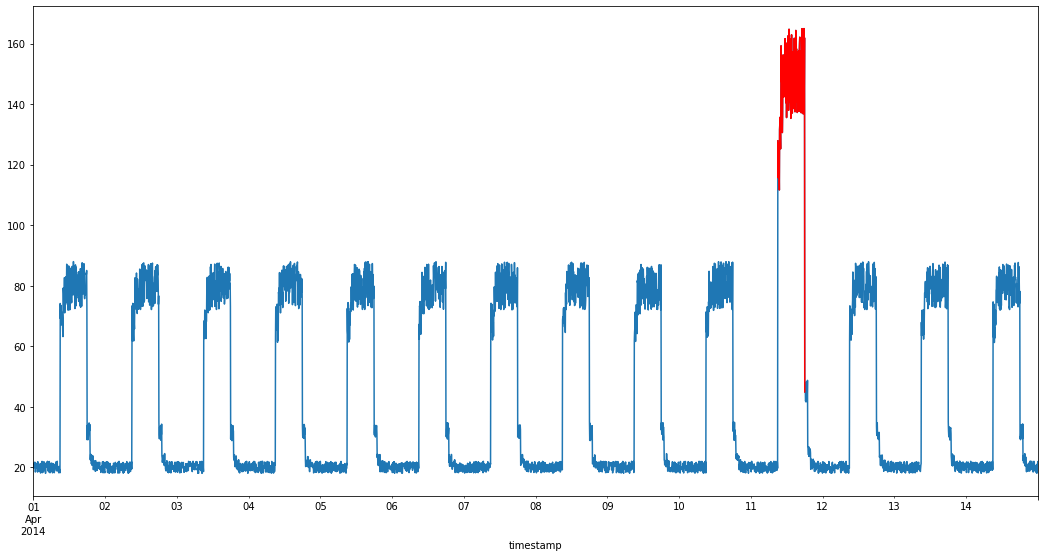

In [33]:
fig, ax = plt.subplots(figsize=(18,9))
df_daily_anomaly.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show;